In [ ]:
import os
from pathlib import Path
import random
from typing import Dict
import numpy as np
import pandas as pd
from PIL import Image

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, models
import torchvision.transforms.functional as TF

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.models as models

In [2]:
try:
    import timm
except ImportError:
    timm = None
    print("Install timm for Xception support")


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
def gather_file_list(paths_map: Dict[str, str]) -> pd.DataFrame:
    rows = []
    for key, p in paths_map.items():
        p = Path(p)
        label = 'fake' if 'fake' in key else 'real'
        split = key.split('_')[0]

        for f in p.rglob('*'):
            if f.suffix.lower() in ('.jpg','.png','.jpeg','.bmp','.webp'):
                rows.append({
                    'filepath': str(f),
                    'label': label,
                    'split': split,
                    'parent_dir': f.parent.name
                })
    return pd.DataFrame(rows)


In [4]:
AUG_PATHS = {
    'train_fake': '/kaggle/input/lowlight-dataset/train_fake',
    'train_real': '/kaggle/input/lowlight-dataset/train_real',
    'valid_fake': '/kaggle/input/lowlight-dataset/valid_fake',
    'valid_real': '/kaggle/input/lowlight-dataset/valid_real',
    'test_fake':  '/kaggle/input/lowlight-dataset/test_fake',
    'test_real':  '/kaggle/input/lowlight-dataset/test_real',
}

df_all = gather_file_list(AUG_PATHS)


In [5]:
print(df_all['split'].value_counts())

split
train    165597
valid     17348
test       6768
Name: count, dtype: int64


## Dataset class

In [6]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

In [7]:
class WildDeepfakeDataset(Dataset):
    def __init__(self, df, train=True, img_size=224):
        self.df = df.reset_index(drop=True)
        self.label_map = {'real':0, 'fake':1}

        if train:
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomResizedCrop(img_size, scale=(0.7,1.0)),
                transforms.ToTensor()
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((img_size,img_size)),
                transforms.ToTensor()
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['filepath']).convert("RGB")
        img = self.transform(img)
        return img, self.label_map[row['label']]


## Retinex Layer

In [8]:
class RetinexLayer(nn.Module):
    def __init__(self, kernel_size: int = 7, sigma: float = 3.0):
        super().__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma

        coords = torch.arange(kernel_size).float() - (kernel_size - 1) / 2.0
        grid = coords.unsqueeze(0) ** 2 + coords.unsqueeze(1) ** 2
        kernel = torch.exp(-grid / (2 * sigma * sigma))
        kernel = kernel / kernel.sum()
        self.register_buffer('kernel', kernel[None, None, :, :])  # [1,1,k,k]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        eps = 1e-4
        x_clamped = x.clamp(0.0, 1.0)

        kernel = self.kernel.to(x.device, x.dtype)
        kernel = kernel.expand(C, 1, self.kernel_size, self.kernel_size)
        illum = F.conv2d(
            x_clamped,
            kernel,
            padding=self.kernel_size // 2,
            groups=C,
        )
        reflect = torch.log(x_clamped + eps) - torch.log(illum + eps)
        # normalize per-channel
        reflect_min = reflect.amin(dim=[2,3], keepdim=True)
        reflect_max = reflect.amax(dim=[2,3], keepdim=True)
        reflect = (reflect - reflect_min) / (reflect_max - reflect_min + eps)
        return reflect

## SE Block

In [9]:
class SqueezeExcitation(nn.Module):
    def __init__(self, channels: int, reduction: int = 16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

## ResNet34 + Retinex + SE

In [10]:
class ResNet34SERetinex(nn.Module):
    def __init__(self, num_classes=2, dropout=0.5):
        super().__init__()

        self.retinex = RetinexLayer()
        self.normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)

        backbone = models.resnet34(
            weights=models.ResNet34_Weights.IMAGENET1K_V1
        )

        self.stem = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool,
        )

        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4

        self.se = SqueezeExcitation(512)
        self.pool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

        nn.init.xavier_normal_(self.classifier[1].weight)

    def forward(self, x):
        x = self.retinex(x)
        x = self.normalize(x)

        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.se(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


## ResNet34 without RetNix + SE block

In [11]:
class ResNet34Plain(nn.Module):
    def __init__(self, num_classes=2, dropout=0.5):
        super().__init__()
        backbone = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        self.stem = nn.Sequential(
            backbone.conv1, backbone.bn1, backbone.relu, backbone.maxpool
        )
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = torch.flatten(x,1)
        return self.classifier(x)

## ResNet34 with SE Only

In [12]:
class ResNet34SEOnly(ResNet34Plain):
    def __init__(self, num_classes=2, dropout=0.4):
        super().__init__(num_classes, dropout)
        self.se = SqueezeExcitation(512)
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.se(x)
        x = self.pool(x)
        x = torch.flatten(x,1)
        return self.classifier(x)

## ResNet34 Retinex Only

In [13]:
class ResNet34RetinexOnly(ResNet34Plain):
    def __init__(self, num_classes=2, dropout=0.5):
        super().__init__(num_classes, dropout)
        self.retinex = RetinexLayer()
        self.normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    def forward(self, x):
        x = self.retinex(x)
        x = self.normalize(x)
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = torch.flatten(x,1)
        return self.classifier(x)

## Xception + Retinex

In [22]:
class XceptionRetinex(nn.Module):
    def __init__(self, num_classes=2, dropout=0.5):
        super().__init__()

        self.retinex = RetinexLayer()
        self.normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)

        self.model = timm.create_model(
            "xception",
            pretrained=True,
            num_classes=num_classes,
            drop_rate=dropout
        )

    def forward(self, x):
        x = self.retinex(x)
        x = self.normalize(x)
        return self.model(x)

## Xception without Retinex

In [23]:
class XceptionPlain(nn.Module):
    def __init__(self, num_classes=2, dropout=0.5):
        super().__init__()
        self.model = timm.create_model(
            "xception",
            pretrained=True,
            num_classes=num_classes,
            drop_rate=dropout
        )

    def forward(self, x):
        return self.model(x)

## EfficientNet-B0 without Retinex

In [24]:
class EfficientNetB0Plain(nn.Module):
    def __init__(self, num_classes=2, dropout=0.5):
        super().__init__()
        backbone = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
        )

        in_features = backbone.classifier[1].in_features
        backbone.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes)
        )
        self.model = backbone

    def forward(self, x):
        return self.model(x)

## EfficientNet-B0 + Retinex

In [25]:
class EfficientNetB0Retinex(nn.Module):
    def __init__(self, num_classes=2, dropout=0.5):
        super().__init__()

        self.retinex = RetinexLayer()
        self.normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)

        backbone = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
        )

        in_features = backbone.classifier[1].in_features
        backbone.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes)
        )

        self.model = backbone

    def forward(self, x):
        x = self.retinex(x)
        x = self.normalize(x)
        return self.model(x)


##  LIDeepDet

In [26]:
class LIDeepDet(nn.Module):
    def __init__(self, num_classes=2, dropout=0.5):
        super().__init__()

        self.enhance = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 1)
        )

        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        self.stem = nn.Sequential(
            backbone.conv1, backbone.bn1, backbone.relu, backbone.maxpool
        )
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4
        
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        # enhancement for low-light
        x = x + self.enhance(x)               
        x = torch.clamp(x, 0, 1)              

        # feature extraction
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)





## LIDeepDet + Retinex 

In [27]:
class LIDeepDet_Retinex(nn.Module):
    def __init__(self, num_classes=2, dropout=0.4):
        super().__init__()
        self.retinex = RetinexLayer()
        self.normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
        self.lid = LIDeepDet(num_classes=num_classes, dropout=dropout)

    def forward(self, x):
        x = self.retinex(x)               
        x = self.normalize(x)
        return self.lid(x)

## Model Factory

In [28]:
def create_model(name):
    name = name.lower()

    # ===== ResNet34 Variants =====
    if name == "resnet34_se_retinex":       return ResNet34SERetinex()
    elif name == "resnet34_plain":          return ResNet34Plain()
    elif name == "resnet34_se_only":        return ResNet34SEOnly()
    elif name == "resnet34_retinex_only":   return ResNet34RetinexOnly()


    # ===== Xception Variants =====
    elif name == "xception_retinex":        return XceptionRetinex()
    elif name == "xception_plain":          return XceptionPlain()

    # ===== EfficientNet-B0 Variants =====
    elif name == "efficientnetb0_retinex":  return EfficientNetB0Retinex()
    elif name == "efficientnetb0_plain":    return EfficientNetB0Plain()

    # ===== Low-Illumination LIDeepDet Models =====
    elif name == "lideepdet":             return LIDeepDet()
    elif name == "lideepdet_retinex":     return LIDeepDet_Retinex()

    else:
        raise ValueError("Unknown model:", name)

   

# قائمة النماذج المتاحة
AVAILABLE_MODELS = [
    "resnet34_se_retinex",
    "resnet34_plain",
    "resnet34_se_only",
    "resnet34_retinex_only",
    "xception_retinex",
    "xception_plain",
    "efficientnetb0_retinex",
    "efficientnetb0_plain",
    "lideepdet",
    "lideepdet_retinex"
]


In [29]:
def compute_metrics(y, p, prob):
    return {
        "acc": accuracy_score(y,p),
        "f1": f1_score(y,p),
        "auc": roc_auc_score(y,prob)
    }


# Cross-Validation Training

In [30]:
from sklearn.model_selection import StratifiedKFold

In [31]:
def train_with_cv(
    model_name,
    epochs=10,
    batch_size=32,
    lr=1e-4,
    n_splits=5
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

   
    df_train = df_all[df_all['split'] != 'test'].copy()

   
    df_train["group"] = df_train["parent_dir"] + "_" + df_train["label"]

    y = df_train["label"].map({"real": 0, "fake": 1}).values
    groups = df_train["group"].values

    skf = skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)


    fold_aucs = []

    for fold, (tr, val) in enumerate(skf.split(df_train, y)):
        print(f"\n===== Fold {fold+1}/5 =====")
        

        
        train_ds = WildDeepfakeDataset(df_train.iloc[tr], train=True)
        val_ds   = WildDeepfakeDataset(df_train.iloc[val], train=False)

        train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)
        val_loader   = DataLoader(val_ds, batch_size, shuffle=False, num_workers=4)

        model = create_model(model_name).to(device)
        opt = torch.optim.AdamW(model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

        best_auc = 0

        for ep in range(epochs):
            model.train()
            for x, yb in train_loader:
                x, yb = x.to(device), yb.to(device)
                opt.zero_grad()
                loss = loss_fn(model(x), yb)
                loss.backward()
                opt.step()

            model.eval()
            yt, pr = [], []
            with torch.no_grad():
                for x, yb in val_loader:
                    x = x.to(device)
                    logits = model(x)
                    prob = torch.softmax(logits, 1)[:, 1]
                    yt += yb.tolist()
                    pr += prob.cpu().tolist()

            # ===== SAFE AUC =====
            if len(np.unique(yt)) < 2:
                print("⚠️ Fold فيه كلاس واحد – AUC تم تخطيه")
                auc = 0.5
            else:
                auc = roc_auc_score(yt, pr)

            best_auc = max(best_auc, auc)

        fold_aucs.append(best_auc)
        print("Fold AUC:", best_auc)

    print("\nCV RESULT")
    print("Mean AUC:", np.mean(fold_aucs))
    print("Std  AUC:", np.std(fold_aucs))


In [32]:
train_with_cv(
    model_name="lideepdet",   # or resnet34, resnet50, efficientnet_b0
    epochs=2,
    batch_size=16,
    lr=1e-4
)



===== Fold 1/5 =====
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 219MB/s] 


Fold AUC: 0.9753688212549452

===== Fold 2/5 =====
Fold AUC: 0.9858291142804564

===== Fold 3/5 =====
Fold AUC: 0.9867119879642058

===== Fold 4/5 =====
Fold AUC: 0.9847559062265843

===== Fold 5/5 =====
Fold AUC: 0.9856169244405302

CV RESULT
Mean AUC: 0.9836565508333444
Std  AUC: 0.004190318281883683


# Final Training on FULL TRAIN+VALID

In [33]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

def compute_epoch_metrics(y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)

    if len(np.unique(y_true)) > 1:
        auc = roc_auc_score(y_true, y_prob)
    else:
        auc = np.nan

    return acc, f1, auc


In [34]:
def train_final_model(
    model_name,
    epochs=10,
    batch_size=32,
    lr=1e-4,
    save_path="best_model.pth",
    patience=5              
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ===== DATA =====
    train_df = df_all[df_all["split"] == "train"]
    val_df   = df_all[df_all["split"] == "valid"]

    train_ds = WildDeepfakeDataset(train_df, train=True)
    val_ds   = WildDeepfakeDataset(val_df, train=False)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

    # ===== MODEL =====
    model = create_model(model_name).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

    # ===== EARLY STOP TRACKERS =====
    best_val_auc = -1
    best_epoch = -1
    best_stats = {}
    no_improve_epochs = 0

    # ===== METRIC TRACKERS (FOR CURVES) =====
    epochs_list = []
    val_auc_list = []
    val_acc_list = []
    val_f1_list = []

    print("Epoch | TrainLoss | ValLoss | TrainAcc | ValAcc | TrainF1 | ValF1 | TrainAUC | ValAUC")

    for epoch in range(1, epochs + 1):

        # -------- TRAIN --------
        model.train()
        train_losses, yt, yp, pr = [], [], [], []

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(imgs)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            prob = torch.softmax(logits, 1)[:, 1]
            pred = logits.argmax(1)

            yt.extend(labels.cpu().numpy())
            yp.extend(pred.cpu().numpy())
            pr.extend(prob.detach().cpu().numpy())

        train_loss = np.mean(train_losses)
        train_acc, train_f1, train_auc = compute_epoch_metrics(yt, yp, pr)

        # -------- VALIDATION --------
        model.eval()
        val_losses, yt, yp, pr = [], [], [], []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                logits = model(imgs)
                loss = loss_fn(logits, labels)

                val_losses.append(loss.item())
                prob = torch.softmax(logits, 1)[:, 1]
                pred = logits.argmax(1)

                yt.extend(labels.cpu().numpy())
                yp.extend(pred.cpu().numpy())
                pr.extend(prob.cpu().numpy())

        val_loss = np.mean(val_losses)
        val_acc, val_f1, val_auc = compute_epoch_metrics(yt, yp, pr)

        # ===== SAVE METRICS FOR CURVES =====
        epochs_list.append(epoch)
        val_auc_list.append(val_auc)
        val_acc_list.append(val_acc)
        val_f1_list.append(val_f1)

        # -------- LOGGING --------
        print(
            f"{epoch:02d} | {train_loss:.4f} | {val_loss:.4f} | "
            f"{train_acc:.4f} | {val_acc:.4f} | "
            f"{train_f1:.4f} | {val_f1:.4f} | "
            f"{train_auc:.4f} | {val_auc:.4f}"
        )

        # ===== CHECK IMPROVEMENT =====
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_epoch = epoch
            no_improve_epochs = 0

            best_stats = {
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "train_f1": train_f1,
                "val_f1": val_f1,
                "train_auc": train_auc,
                "val_auc": val_auc
            }

            torch.save(model.state_dict(), save_path)

        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs} epoch(s).")

        # ===== EARLY STOP CONDITION =====
        if no_improve_epochs >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}.")
            break

    # ================================
    # FINAL SUMMARY
    # ================================
    print("\n================ BEST RESULT ================")
    print(f"Best Epoch : {best_epoch}")
    print(f"Train Loss : {best_stats['train_loss']:.4f}")
    print(f"Val Loss   : {best_stats['val_loss']:.4f}")
    print(f"Train Acc  : {best_stats['train_acc']:.4f}")
    print(f"Val Acc    : {best_stats['val_acc']:.4f}")
    print(f"Train F1   : {best_stats['train_f1']:.4f}")
    print(f"Val F1     : {best_stats['val_f1']:.4f}")
    print(f"Train AUC  : {best_stats['train_auc']:.4f}")
    print(f"Val AUC    : {best_stats['val_auc']:.4f}")
    print("============================================")
    print(f"✔ Best model saved to {save_path}")

    # ================================
    # PLOT VALIDATION CURVES
    # ================================
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10,5))
    plt.plot(epochs_list, val_auc_list, label="Val AUC")
    plt.plot(epochs_list, val_acc_list, label="Val Accuracy")
    plt.plot(epochs_list, val_f1_list, label="Val F1")

    if best_epoch in epochs_list:
        plt.axvline(best_epoch, linestyle="--", alpha=0.6, label=f"Best Epoch {best_epoch}")

    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title(f"Validation Metrics — {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [35]:
def evaluate_on_test(model_name, checkpoint_path, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = create_model(model_name).to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    test_df = df_all[df_all['split'] == 'test']
    test_ds = WildDeepfakeDataset(test_df, train=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            logits = model(imgs)

            prob = torch.softmax(logits, dim=1)[:, 1]
            pred = logits.argmax(1)

            y_true.extend(labels.numpy())
            y_pred.extend(pred.cpu().numpy())
            y_prob.extend(prob.cpu().numpy())

    print("\n===== TEST RESULTS =====")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score : {f1_score(y_true, y_pred):.4f}")
    print(f"AUC      : {roc_auc_score(y_true, y_prob):.4f}")

    return y_true, y_pred, y_prob


# TEST EVALUATION

# Confusion Matrix + ROC Curve

In [36]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Real","Fake"],
                yticklabels=["Real","Fake"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()


# FINAL EXECUTION

Epoch | TrainLoss | ValLoss | TrainAcc | ValAcc | TrainF1 | ValF1 | TrainAUC | ValAUC
01 | 0.4133 | 0.5020 | 0.8626 | 0.8108 | 0.8572 | 0.8253 | 0.9371 | 0.8865
02 | 0.3064 | 0.4758 | 0.9376 | 0.8295 | 0.9352 | 0.8366 | 0.9818 | 0.9047
03 | 0.2766 | 0.5304 | 0.9558 | 0.8071 | 0.9542 | 0.8196 | 0.9894 | 0.8816
No improvement for 1 epoch(s).
04 | 0.2599 | 0.4988 | 0.9654 | 0.8200 | 0.9642 | 0.8317 | 0.9930 | 0.8952
No improvement for 2 epoch(s).
05 | 0.2497 | 0.5833 | 0.9714 | 0.7928 | 0.9704 | 0.7909 | 0.9947 | 0.8700
No improvement for 3 epoch(s).
06 | 0.2424 | 0.5050 | 0.9756 | 0.8238 | 0.9747 | 0.8333 | 0.9958 | 0.8975
No improvement for 4 epoch(s).
07 | 0.2370 | 0.5076 | 0.9789 | 0.8240 | 0.9782 | 0.8359 | 0.9966 | 0.8940
No improvement for 5 epoch(s).

Early stopping triggered at epoch 7.

================ BEST RESULT ================
Best Epoch : 2
Train Loss : 0.3064
Val Loss   : 0.4758
Train Acc  : 0.9376
Val Acc    : 0.8295
Train F1   : 0.9352
Val F1     : 0.8366
Train AUC  : 0

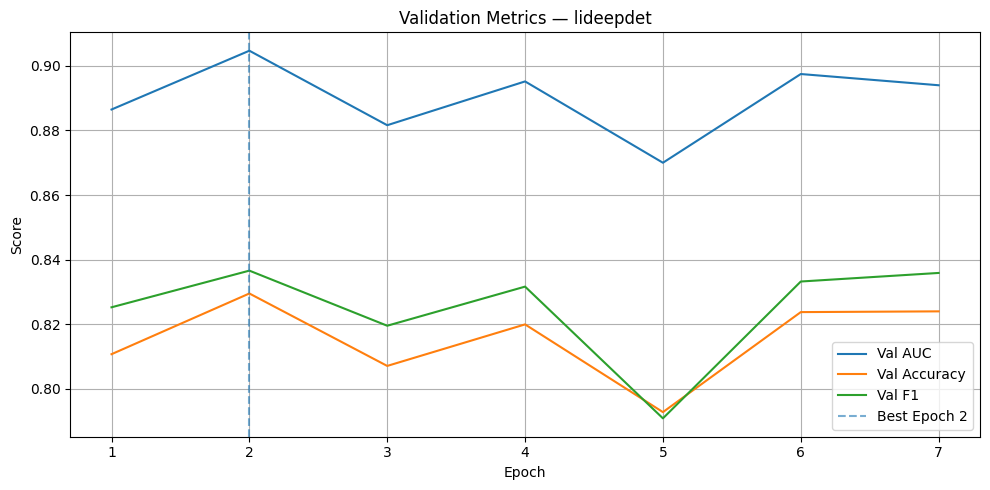

In [37]:
train_final_model(
    model_name="lideepdet",
    epochs=15,
    batch_size=16,
    lr=1e-4,
    patience=5,
    save_path="lideepdet.pth"
)


In [38]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix


===== TEST RESULTS =====
Accuracy : 0.8202
Precision: 0.8530
Recall   : 0.7755
F1 Score : 0.8124
AUC      : 0.8991


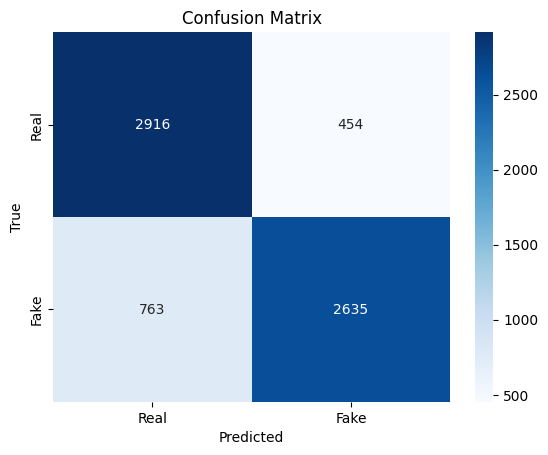

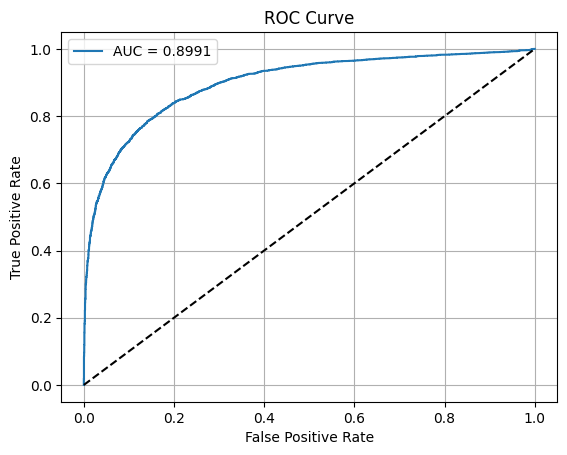

In [39]:
y_true, y_pred, y_prob = evaluate_on_test(
    model_name="lideepdet",
    checkpoint_path="lideepdet.pth"
)

plot_confusion_matrix(y_true, y_pred)
plot_roc_curve(y_true, y_prob)


## Training Best Model with Best hyperparameter for datasizes

In [32]:
def evaluate_model(model, loader, device):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            logits = model(imgs)

            prob = torch.softmax(logits, 1)[:, 1]
            pred = logits.argmax(1)

            y_true.extend(labels.numpy())
            y_pred.extend(pred.cpu().numpy())
            y_prob.extend(prob.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)

    if len(np.unique(y_true)) > 1:
        auc = roc_auc_score(y_true, y_prob)
    else:
        auc = np.nan

    return acc, auc


In [34]:
def train_one_size(
    model_name,
    train_df,
    val_df,
    epochs=15,
    patience=5,
    batch_size=16,
    lr=2e-4,
    weight_decay=1e-4   
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_ds = WildDeepfakeDataset(train_df, train=True)
    val_ds   = WildDeepfakeDataset(val_df, train=False)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

    model = create_model(model_name).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )

    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

    best_val_auc = -1
    no_improve = 0

    for epoch in range(1, epochs + 1):
        # -------- TRAIN --------
        model.train()
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = loss_fn(model(imgs), labels)
            loss.backward()
            optimizer.step()

        # -------- VALID --------
        _, val_auc = evaluate_model(model, val_loader, device)

        # -------- EARLY STOP --------
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # -------- FINAL METRICS --------
    train_acc, train_auc = evaluate_model(model, train_loader, device)
    val_acc, val_auc     = evaluate_model(model, val_loader, device)

    return train_acc, train_auc, val_acc, val_auc


In [ ]:
fractions = [0.25 , 0.5 , 0.75,1.0]

train_df_full = df_all[df_all["split"] == "train"].reset_index(drop=True)
val_df        = df_all[df_all["split"] == "valid"].reset_index(drop=True)

sizes = []
train_accs, val_accs = [], []
train_aucs, val_aucs = [], []

for frac in fractions:
    subset_size = int(len(train_df_full) * frac)
    subset_df = train_df_full.sample(
        n=subset_size,
        random_state=42,
        replace=False
    )

    print(f"\nTraining with {subset_size} samples ({int(frac*100)}%)")

    tr_acc, tr_auc, va_acc, va_auc = train_one_size(
        model_name="xception_plain",
        train_df=subset_df,
        val_df=val_df,
        epochs=15,
        patience=5,# keep small (learning curve proxy)
        batch_size=16,
        lr=2e-4
    )

    sizes.append(subset_size)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)
    train_aucs.append(tr_auc)
    val_aucs.append(va_auc)

    print(
    f"Train Acc={tr_acc:.4f} | Train AUC={tr_auc:.4f} || "
    f"Val Acc={va_acc:.4f} | Val AUC={va_auc:.4f}"
)




Training with 41399 samples (25%)
Early stopping at epoch 8
Train Acc=0.9862 | Train AUC=0.9986 || Val Acc=0.7953 | Val AUC=0.8695

Training with 82798 samples (50%)


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [ ]:
plt.figure(figsize=(8,5))
plt.plot(sizes, train_accs, marker="o", label="Train Accuracy")
plt.plot(sizes, val_accs, marker="o", label="Validation Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve — Accuracy vs Dataset Size")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(8,5))
plt.plot(sizes, train_aucs, marker="o", label="Train AUC")
plt.plot(sizes, val_aucs, marker="o", label="Validation AUC")
plt.xlabel("Training Set Size")
plt.ylabel("AUC")
plt.title("Learning Curve — AUC vs Dataset Size")
plt.legend()
plt.grid(True)
plt.show()
